# XGBoost

# Initialize

## Packages

### General

In [1]:
import os, sys
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from importlib import reload

Save data to Google Drive

In [2]:
try:
    from google.colab import drive
    drive.mount('/content/drive/')
    print("Running in Google Colab")
    in_colab=True
except:
    print("Running locally")
    in_colab=False

Running locally


Formatting

In [3]:
# For ASCII plots of training progress
try:
    import asciichartpy
except ImportError:
    !pip install asciichartpy
    import asciichartpy

from IPython.display import clear_output

### ML

In [4]:
import pandas as pd
from xgboost import XGBRegressor

### Helper functions

In [49]:
# Computes MAE for two numpy arrays
maef = lambda y_pred, data: (y_pred - data).abs().mean()

In [65]:
import my_functions as mine

## Data

### Get data

In [5]:
!wget https://github.com/ageron/data/raw/main/ridership.tgz
!mkdir data
!mv ridership.tgz data
!tar -xvzf data/ridership.tgz --directory=data/

--2025-04-11 15:44:50--  https://github.com/ageron/data/raw/main/ridership.tgz
Resolving github.com (github.com)... 140.82.116.4
connected. to github.com (github.com)|140.82.116.4|:443... 
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ageron/data/main/ridership.tgz [following]
--2025-04-11 15:44:51--  https://raw.githubusercontent.com/ageron/data/main/ridership.tgz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108512 (106K) [application/octet-stream]
Saving to: ‘ridership.tgz’

ridership.tgz       100%[===================>] 105.97K  --.-KB/s    in 0.05s   

2025-04-11 15:44:51 (2.01 MB/s) - ‘ridership.tgz’ saved [108512/108512]

mkdir: data: File exists
x ridership/
x ridership/CTA_-_Ridership_-_Daily_Boardin

In [6]:
# read data
path = Path("data/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])

# some cleaning
df.columns = ["date", "day_type", "bus", "rail", "total"]  # shorter names
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)  # no need for total, it's just bus + rail
df = df.drop_duplicates()  # remove duplicated months (2011-10 and 2014-07)

### Prepares data

Our goal will be to forecast tomorrow’s ridership based
on the ridership of the past 8 weeks of data (56 days). The inputs to our model
will therefore be sequences (usually a single sequence per day once the model is in
production), each containing 56 values from time steps $t – 55$ to $t$. For each input
sequence, the model will output 14 values in a sequence to vector fashion: the forecasts for time step $t + 14$.

Before we continue looking at the data, let's **split the time series into three periods, for training, validation and testing**. We won't look at the test data for now:

In [7]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

Defines the dataframe and features. Now `df_mulvar` is a DataFrame with five columns: the bus and rail data, plus three
columns containing the one-hot encoding of the next day’s type (recall that there are
three possible day types, W, A, and U).

In [8]:
df_mulvar = df[["bus", "rail"]] / 1e6  # use both bus & rail series as input
df_mulvar["next_day_type"] = df["day_type"].shift(-1)  # we know tomorrow's type
df_mulvar = pd.get_dummies(df_mulvar, dtype=int)  # one-hot encode the day type

In [9]:
df_mulvar.head()

,bus,rail,next_day_type_A,next_day_type_U,next_day_type_W
date,,,,,
2001-01-01,0.297192,0.126455,0,0,1
2001-01-02,0.780827,0.501952,0,0,1
2001-01-03,0.824923,0.536432,0,0,1
2001-01-04,0.870021,0.550011,0,0,1
2001-01-05,0.890426,0.557917,1,0,0


Next we can proceed much like we did earlier.
First we split the data into three periods, for training, validation, and testing:

In [10]:
mulvar_train = df_mulvar["2016-01":"2018-12"]
mulvar_valid = df_mulvar["2019-01":"2019-05"]
mulvar_test = df_mulvar["2019-06":]

Training and validation data

In [11]:
ahead = 14       # forecast horizon
seq_length=56

# XGboost model

**Reframe the Time Series as a Supervised Learning Problem**

XGBoost expects a feature matrix where each row is an independent sample. In time series forecasting you can create these samples by using a sliding window (or lag features). For each sample, you’ll create a feature vector by taking the past 56 days of data (all 5 features) and "flattening" them into a 1D array. Your target will be the next day’s value of **column 1**.  

For example, if you have \( t=0,1,\dots,N \) days, then for each day \( t \) starting from the 56-th day (i.e., \( t = 56 \)), the input will be time steps \( t-56 \) to \( t-1 \) (a 56-day window) and the target will be the value at time \( t \) from column 1.

## Prepare the Data

You need to:
- Loop through the time series data.
- For each valid time index (after the first 56 days), create a feature vector by flattening the last 56 days of records.
- Extract the target corresponding to column 1 of the day following the window.

In [20]:
def create_dataset(data, window_size, target_col):
    """
    Converts sequential time series data into a supervised learning dataset.
    
    Parameters:
      data (numpy array): Input data of shape (num_days, num_features).
      window_size (int): The number of past days to use.
      target_col (int): The column index for the target value.
      
    Returns:
      X (numpy array): Feature matrix of flattened past window values.
      y (numpy array): Target vector (the next day’s value for target_col).
    """
    X, y = [], []
    for i in range(window_size, len(data)):
        # Flatten a window of shape (window_size, num_features) into (window_size*num_features,)
        X.append(data[i-window_size:i].flatten())
        y.append(data[i, target_col])
    return np.array(X), np.array(y)

## Split Data into Train and Validation Sets

Assuming you have already loaded your training and validation datasets (for example, `mulvar_train` and `mulvar_val` as numpy arrays), create the datasets as follows:

In [30]:
# Parameters
window_size = seq_length
target_col = 1  # Predicting the next value for column 1

# Create datasets for training and validation
X_train, y_train = create_dataset(mulvar_train.to_numpy(), window_size, target_col)
X_val, y_val = create_dataset(mulvar_valid.to_numpy(), window_size, target_col)

## Train XGBoost

We use the `XGBRegressor` from the xgboost library. Configure the hyperparameters, and use early stopping on your validation set to help prevent overfitting.

In [33]:
from sklearn.metrics import mean_squared_error

# Define the model
model = XGBRegressor(
    n_estimators=1000,          # You may adjust
    learning_rate=0.01,         # Low learning rate for gradual learning
    max_depth=5,                # Depth of trees, adjust based on complexity
    subsample=0.8, 
    colsample_bytree=0.8, 
    random_state=42
)

# Train the model with early stopping based on the validation set
model.fit(
    X_train, 
    y_train,
    eval_set=[(X_val, y_val)])

[0]	validation_0-rmse:0.17754
[1]	validation_0-rmse:0.17595
[2]	validation_0-rmse:0.17430
[3]	validation_0-rmse:0.17272
[4]	validation_0-rmse:0.17117
[5]	validation_0-rmse:0.16963
[6]	validation_0-rmse:0.16814
[7]	validation_0-rmse:0.16664
[8]	validation_0-rmse:0.16517
[9]	validation_0-rmse:0.16373
[10]	validation_0-rmse:0.16225
[11]	validation_0-rmse:0.16080
[12]	validation_0-rmse:0.15943
[13]	validation_0-rmse:0.15806
[14]	validation_0-rmse:0.15661
[15]	validation_0-rmse:0.15519
[16]	validation_0-rmse:0.15378
[17]	validation_0-rmse:0.15239
[18]	validation_0-rmse:0.15106
[19]	validation_0-rmse:0.14975
[20]	validation_0-rmse:0.14840
[21]	validation_0-rmse:0.14717
[22]	validation_0-rmse:0.14595
[23]	validation_0-rmse:0.14471
[24]	validation_0-rmse:0.14339
[25]	validation_0-rmse:0.14211
[26]	validation_0-rmse:0.14091
[27]	validation_0-rmse:0.13968
[28]	validation_0-rmse:0.13845
[29]	validation_0-rmse:0.13726
[30]	validation_0-rmse:0.13605
[31]	validation_0-rmse:0.13489
[32]	validation_0-

In [34]:
# Validate performance
predictions = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, predictions))
print(f"Validation RMSE: {rmse:.4f}")

Validation RMSE: 0.0344


## Forecasting in Production

When you want to forecast the next ridership value (i.e., tomorrow’s value) in production, you need to:
- Gather the most recent 56 days of data.
- Convert these into the same flattened format as used during training.
- Use the trained model to predict.

Get the forecast

In [51]:
# Assume latest_window is a numpy array of shape (56, num_features) for the past 56 days
# Flatten the window into a single feature vector:
latest_flat = mulvar_valid[:seq_length].to_numpy().flatten().reshape(1, -1)
y_p = model.predict(latest_flat)

In [66]:
y_p=mine.forecast_mulvar_xgb(seq_length, mulvar_valid, model, 'rail')

In [60]:
mae=maef(y_p, rail_valid[seq_length+1])*1e6
print(mae)

146102.81586647034


/var/folders/15/7jdf1bc547qf4cwtcvv8g05h0000gn/T/ipykernel_3359/2998288074.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mae=maef(y_p, rail_valid[seq_length+1])*1e6


/var/folders/15/7jdf1bc547qf4cwtcvv8g05h0000gn/T/ipykernel_3359/3904755034.py:3: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax.plot(y_p, marker=".", label="Model")


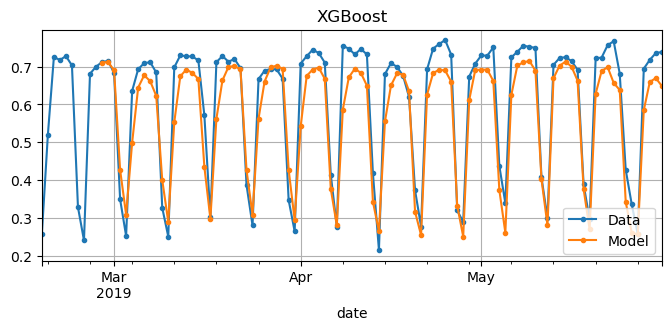

In [64]:
fig, ax = plt.subplots(figsize=(8, 3))
rail_valid.loc[y_p.index[0]-pd.Timedelta(days=10):rail_valid.index[-1]].plot(label="Data", ax=ax, marker=".", grid=True)
ax.plot(y_p, marker=".", label="Model")
plt.legend(fontsize=10, loc='lower right')
plt.title("XGBoost")
plt.show()